# ex-22 Produce Future Temporal Curve in New Zealand

Producing future temporal curve is quite complicated, which requires a few inputs and some statistical/mathematical computions.

## Requirements

Producing future DDFs requires
- 1. Baseline (or historical) DDFs
- 2. Global mean temperature change (dgmt, degC)
- 3. Extreme precipitation GEV pattern (%/degC)

## Math formula for future DDFs
- Future DDFs = Historical DDFs * (1.0 + dgmt * pattern/100.0)

Note: 

    Due to big sptial variability, we generally do not apply the gobal pattern directly. 
    We recommended applying a spatially smoothing precedure first to seek a relatively stable spatial pattern.
    However, there is not a starndard for that.

    After several trials, we think that it should be feasible to create individual GEV patterns for each climate zone.

## Data sources

##### Shapefile climate zones in New Zealand (6 climate zones in total)

    data/NZ_ClimateZone
![cz](data/climatezones.png)
##### The smoothed GEV pattern for NZ is available at
   > data/New Zealand_Extreme_Precipitation_Pattern_AR6.nc

##### Global mean temperature change curve could be found at

    data/IPCC_AR6_GMT_curves.csv or
    /media/AsustorOne_Shared/AR6_patterns_changes_for API/IPCC_AR6_GMT_curves.csv

##### Global GEV pattern could be found at
    /media/AsustorOne_Shared/AR6_patterns_changes_for API/Global_Extreme_Precipitation_pattern.nc4(only ssp245&585).nc

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd 
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from temporal_curve import temporal_curve_24hr
from temporal_curve import future_ddfs

## 1 Prepare hist DDFs

 Historical DDFs are produced from NIWA's HIRDSv4 DDF. Moreover, each climate zone should have its own historical DDF curve.

    > See notebook ex-11 for more details
  
- However, I am so lazy to copy the code from notebook ex-11. So we simply make a fake historical DDF

***Note:***

    Please use miniutes as units for DDFs as the temporal curve is created for every serveral minutes.

In [2]:
durs_raw = [10,   20,   30,  60,   120,  360, 720, 1440]
ddfs_raw = [23.2, 31.8, 38,  50.7, 66.4, 98.6, 124, 152]

his_ddfs = pd.DataFrame(data=ddfs_raw,
                        index=durs_raw,
                        columns=['ddf']
                       )
his_ddfs.index.name = 'mins'

## 2 Read future GEV patterns

The GEV pattherns have been produced for each climate zone in New Zealand.

    data/New Zealand_Extreme_Precipitation_Pattern_AR6.nc

Here we take ari=100a, ensemble percentile=50 as an example

***Note***:
- The duration in the GEV pattern apply hour as its unit. When transforming to Pandas.DataFrame, please use the unit of minutes.

In [3]:
# read pattern
ari      = 100 # return period in years
ens_ptl  = 50  # 50% ensemble percentile
gev_file = "data/New Zealand_Extreme_Precipitation_Pattern_AR6.nc"

da_cf = xr.open_dataset(gev_file).pattern.sel(ari=ari, 
                                              pth=ens_ptl, 
                                              method='nearest'
                                             ).drop(['ari', 'pth']).sel(CZ="NNI").drop(['CZ'])

# to pandas.DataFrame
df_cf = da_cf.to_dataframe().rename({"pattern":"cf"}, axis=1)
df_cf.index = np.round(df_cf.index*60, 4) # transform duration units to minutes
df_cf.index.name = "mins"
df_cf

,cf
mins,
180,8.565947
360,7.990438
720,7.415257
1440,6.840404
2880,6.265879
4320,5.929956
5760,5.691682
7200,5.506902
8640,5.355951


## 3 Produce future DDFs


Producing future DDFs requires:
- dgmt: global temperature change (in degC)
- gev pattern (%/degC)
- historical DDFs

##### It is worth noting:

The dgmt could be read from the global dgmt curve for different years and scenarios using the following code.
However, I am really lazy as I directly assume dgmt will increase 1.5 degC in the future.

In [4]:
dgmt = 1.5 # we assume global mean tempertaure will increase 1.5 degC in the future

fut_ddfs = future_ddfs(dgmt, df_cf, his_ddfs)

## 4 Future temporal curve

In [5]:
df_crrs_fut = temporal_curve_24hr(fut_ddfs)

##  5 Compare

### 5.1 Temporal curve

Text(0.5, 1.0, 'Temporal Curve for duration=24 hours and ARI=100a\n@dgmt=1.5 degC')

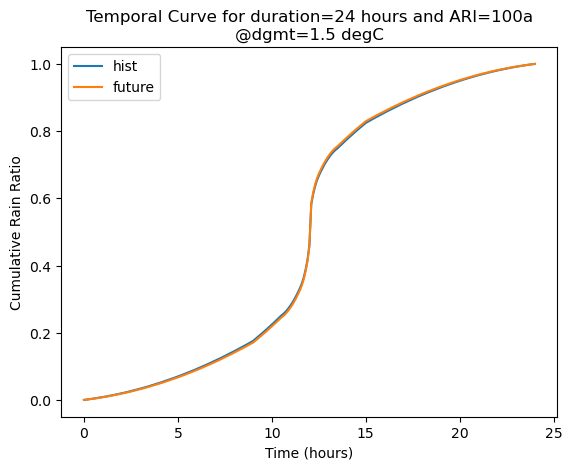

In [6]:
df_crrs_his = temporal_curve_24hr(his_ddfs)

ax = pd.concat([df_crrs_his, df_crrs_fut], axis=1).plot()
ax.legend(['hist', 'future'])
plt.xlabel("Time (hours)")
plt.ylabel("Cumulative Rain Ratio")
plt.title(f"Temporal Curve for duration=24 hours and ARI=100a\n@dgmt=1.5 degC")

### 5.2 Restore temporal curve to real depth

Based on 24-hour (i.e., 1440 minutes) Extreme Preciptation

Text(0.5, 1.0, 'Temporal Precipitation for duration=24 hours and ARI=100a\n@dgmt=1.5 degC')

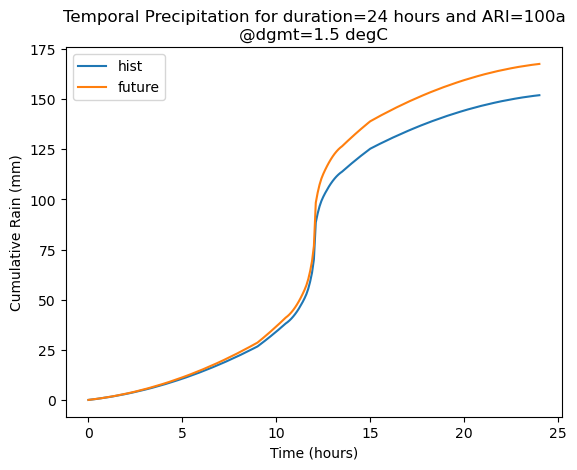

In [7]:
ax = pd.concat([df_crrs_his*his_ddfs.loc[1440].values, 
                df_crrs_fut*fut_ddfs.loc[1440].values
               ], axis=1).plot()

ax.legend(['hist', 'future'])
plt.xlabel("Time (hours)")
plt.ylabel("Cumulative Rain (mm)")
plt.title(f"Temporal Precipitation for duration=24 hours and ARI=100a\n@dgmt=1.5 degC")

### 5.3  DDF curve

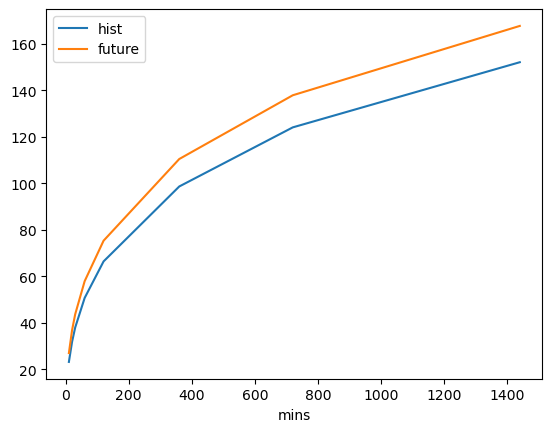

In [8]:
merge_ddfs = pd.concat([his_ddfs, fut_ddfs], axis=1)

ax = merge_ddfs.plot()
ax.legend(['hist', 'future'])